In [1]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pylab as plt

def plot_scores(param, paramName, tr_scores, va_scores, log_scale=False):
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.plot(param, tr_scores)
    plt.plot(param, va_scores)
    plt.legend(['train', 'validation'])
    plt.xlabel(paramName)
    plt.ylabel('Accuracy')
    if log_scale:
        plt.xscale('log')
        
        
from hotgrad.variable import Variable
from torch import FloatTensor
from hotgrad.sequential import Sequential
from hotgrad.functions.layers import Linear
from hotgrad.functions.activations import ReLU, Tanh
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD
from torch import cat

from dataset_generator import generate_dataset

# generate the dataset
X_train, X_test, y_train, y_test = generate_dataset(1000, one_hot_encoding=True)
y_train.data = y_train.data*2-1
y_test.data = y_test.data*2-1

X_train_baselines = X_train.data.numpy()
X_test_baselines = X_test.data.numpy()
y_train_baselines = (y_train.data == 1)[:, 1].numpy()
y_test_baselines = (y_test.data == 1)[:, 1].numpy()

X_train.data = (X_train.data - X_train.data.mean())/X_train.data.std() 
X_test.data = (X_test.data - X_test.data.mean())/X_test.data.std() 

X_all = Variable(cat((X_train.data, X_test.data), 0))
y_all = Variable(cat((y_train.data, y_test.data), 0))

In [2]:
X_train.shape[1]

2

## Baselines: Parameters Tuning

### Logistic regression

Best lambda: 0.11288378916846883
Test score: 0.606


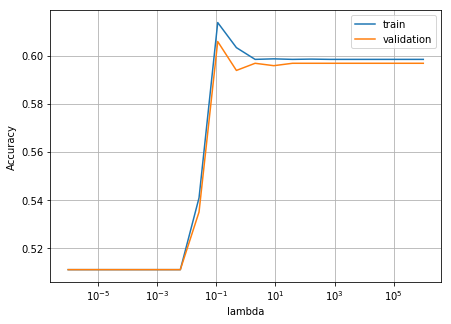

In [3]:
lambdas = np.logspace(-6, 6, 20) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "lambda", logreg["tr_scores"], logreg["va_scores"], log_scale=True)

best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### Random Forest

Best depth: 15
Test score: 0.966


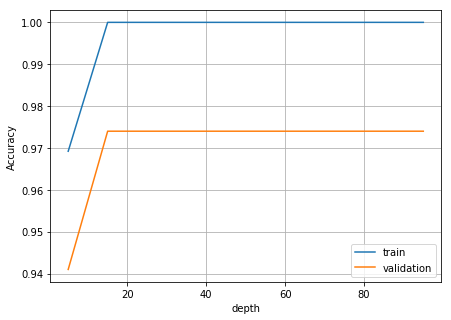

In [4]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], log_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### K-Nearest Neighbors

In [5]:
scaler = StandardScaler()
scaler.fit(X_train_baselines)
X_tr_scaled = scaler.transform(X_train_baselines)
X_te_scaled = scaler.transform(X_test_baselines)
print("standard deviation average:", X_tr_scaled.std(axis=0).mean())
print("mean average:", X_tr_scaled.mean(axis=0).mean())

standard deviation average: 0.99999976
mean average: 4.736185e-07


In [6]:
pca = PCA(n_components=0.95)
pca.fit(X_tr_scaled)
X_tr_scaled = pca.transform(X_tr_scaled)
X_te_scaled = pca.transform(X_te_scaled)
X_tr_scaled.shape, X_te_scaled.shape

((1000, 2), (1000, 2))

Best k: 1
Test score: 0.968


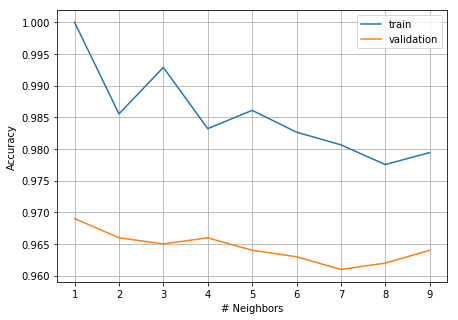

In [7]:
Ks = np.arange(1, 10, 1) # grid search on a parameter of the model

# here we store all the scores obtained with the different number of neighbors
nearestNeig = {
    "tr_scores": [],
    "va_scores": []
}

for k in Ks:
    result = cross_validate(
        KNeighborsClassifier(n_neighbors=k), 
        X_tr_scaled, y_train_baselines, cv=10, return_train_score=True)
    
    nearestNeig["tr_scores"].append(np.mean(result["train_score"]))
    nearestNeig["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(Ks, "# Neighbors", nearestNeig["tr_scores"], nearestNeig["va_scores"], log_scale=False)

best_k = Ks[np.argmax(nearestNeig["va_scores"])]
print('Best k:', best_k)
print('Test score:', 
      KNeighborsClassifier(n_neighbors=k)
      .fit(X_tr_scaled, y_train_baselines)
      .score(X_te_scaled, y_test_baselines))

## Models Comparison

In [8]:
logreg = LogisticRegression(C=best_lambda)
randforest = RandomForestClassifier(n_estimators=100, max_depth=best_depth, n_jobs=-1, random_state=1)
knn = KNeighborsClassifier(n_neighbors=best_k)

# model: two input units, two output units, three hidden layers of 25 units
# model = Sequential([Linear(2,25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Tanh()], MSE(), SGD(lr=0.01))
model = Sequential([Linear(25), ReLU(), Linear(25), ReLU(), Linear(25), ReLU(), Linear(2), Tanh()], MSE(), SGD(lr=0.01))

print("Running cross validation on Logistic Regression...")
logreg_scores = cross_validate(
   logreg,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on Random Forest...")
randforest_scores = cross_validate(
   randforest,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on KNearest Neighbors...")
knn_scores = cross_validate(
   knn,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on the Sequential Module...")
sequential_scores = model.cross_validate(X_all, y_all, batch_size=50, epochs=600, verbose=True, n_splits=4)

Running cross validation on Logistic Regression...
Running cross validation on Random Forest...
Running cross validation on KNearest Neighbors...
Running cross validation on the Sequential Module...
----------------- fold 1/4 -----------------
Epoch 0: Train loss: 47.61035478115082. Train accuracy 49.73%. 
Epoch 1: Train loss: 43.33291161060333. Train accuracy 49.73%. 
Epoch 2: Train loss: 39.00881290435791. Train accuracy 62.20%. 
Epoch 3: Train loss: 29.79789024591446. Train accuracy 49.73%. 
Epoch 4: Train loss: 29.30240398645401. Train accuracy 52.53%. 
Epoch 5: Train loss: 28.9344482421875. Train accuracy 55.00%. 
Epoch 6: Train loss: 28.587265014648438. Train accuracy 56.93%. 
Epoch 7: Train loss: 28.2161967754364. Train accuracy 59.27%. 
Epoch 8: Train loss: 27.81111764907837. Train accuracy 61.53%. 
Epoch 9: Train loss: 27.36175310611725. Train accuracy 62.93%. 
Epoch 10: Train loss: 26.85391104221344. Train accuracy 67.87%. 
Epoch 11: Train loss: 26.274188816547394. Train accu

Epoch 130: Train loss: 1.5273915408179164. Train accuracy 97.93%. 
Epoch 131: Train loss: 1.521542951464653. Train accuracy 97.87%. 
Epoch 132: Train loss: 1.5113608660176396. Train accuracy 97.93%. 
Epoch 133: Train loss: 1.5045189801603556. Train accuracy 97.93%. 
Epoch 134: Train loss: 1.496066759340465. Train accuracy 97.93%. 
Epoch 135: Train loss: 1.4869783334434032. Train accuracy 97.93%. 
Epoch 136: Train loss: 1.4830288207158446. Train accuracy 97.87%. 
Epoch 137: Train loss: 1.4762265076860785. Train accuracy 97.87%. 
Epoch 138: Train loss: 1.4669388667680323. Train accuracy 97.87%. 
Epoch 139: Train loss: 1.460197382606566. Train accuracy 97.87%. 
Epoch 140: Train loss: 1.4510611868463457. Train accuracy 97.87%. 
Epoch 141: Train loss: 1.444323874078691. Train accuracy 97.87%. 
Epoch 142: Train loss: 1.435624664183706. Train accuracy 97.87%. 
Epoch 143: Train loss: 1.430438014678657. Train accuracy 97.93%. 
Epoch 144: Train loss: 1.4223299594596028. Train accuracy 97.87%. 
E

Epoch 258: Train loss: 0.9625781624927185. Train accuracy 99.20%. 
Epoch 259: Train loss: 0.9604235774022527. Train accuracy 99.13%. 
Epoch 260: Train loss: 0.9578972970484756. Train accuracy 99.20%. 
Epoch 261: Train loss: 0.956612566660624. Train accuracy 99.20%. 
Epoch 262: Train loss: 0.9544145402614959. Train accuracy 99.20%. 
Epoch 263: Train loss: 0.9519257021602243. Train accuracy 99.20%. 
Epoch 264: Train loss: 0.9500149343512021. Train accuracy 99.20%. 
Epoch 265: Train loss: 0.9485549179371446. Train accuracy 99.20%. 
Epoch 266: Train loss: 0.9461577042820863. Train accuracy 99.20%. 
Epoch 267: Train loss: 0.9447810828569345. Train accuracy 99.20%. 
Epoch 268: Train loss: 0.9428176917135715. Train accuracy 99.20%. 
Epoch 269: Train loss: 0.9406073948484845. Train accuracy 99.20%. 
Epoch 270: Train loss: 0.9383575241663493. Train accuracy 99.20%. 
Epoch 271: Train loss: 0.9360001831082627. Train accuracy 99.20%. 
Epoch 272: Train loss: 0.9353664748487063. Train accuracy 99.20

Epoch 387: Train loss: 0.7743452179420274. Train accuracy 99.33%. 
Epoch 388: Train loss: 0.7682119065684674. Train accuracy 99.33%. 
Epoch 389: Train loss: 0.7725546540823416. Train accuracy 99.33%. 
Epoch 390: Train loss: 0.7686024326067127. Train accuracy 99.33%. 
Epoch 391: Train loss: 0.768631107865076. Train accuracy 99.33%. 
Epoch 392: Train loss: 0.7694913306695526. Train accuracy 99.33%. 
Epoch 393: Train loss: 0.7636640259661363. Train accuracy 99.33%. 
Epoch 394: Train loss: 0.7656437293771887. Train accuracy 99.33%. 
Epoch 395: Train loss: 0.7656827227838221. Train accuracy 99.33%. 
Epoch 396: Train loss: 0.7590948105462303. Train accuracy 99.33%. 
Epoch 397: Train loss: 0.7636509048061271. Train accuracy 99.33%. 
Epoch 398: Train loss: 0.7597677528683562. Train accuracy 99.33%. 
Epoch 399: Train loss: 0.7606766210919886. Train accuracy 99.33%. 
Epoch 400: Train loss: 0.7602985793419066. Train accuracy 99.33%. 
Epoch 401: Train loss: 0.7559024938636867. Train accuracy 99.33

Epoch 520: Train loss: 0.6085091684844883. Train accuracy 99.40%. 
Epoch 521: Train loss: 0.608696424928894. Train accuracy 99.40%. 
Epoch 522: Train loss: 0.6091516055453212. Train accuracy 99.40%. 
Epoch 523: Train loss: 0.6055882576315526. Train accuracy 99.40%. 
Epoch 524: Train loss: 0.6056917863297713. Train accuracy 99.40%. 
Epoch 525: Train loss: 0.6047945794475709. Train accuracy 99.40%. 
Epoch 526: Train loss: 0.6049990854676253. Train accuracy 99.40%. 
Epoch 527: Train loss: 0.6051970752482703. Train accuracy 99.40%. 
Epoch 528: Train loss: 0.603105629723359. Train accuracy 99.40%. 
Epoch 529: Train loss: 0.6021201492621913. Train accuracy 99.40%. 
Epoch 530: Train loss: 0.6003494841788779. Train accuracy 99.40%. 
Epoch 531: Train loss: 0.6002076199406474. Train accuracy 99.40%. 
Epoch 532: Train loss: 0.6027600701040683. Train accuracy 99.40%. 
Epoch 533: Train loss: 0.5992235595927013. Train accuracy 99.40%. 
Epoch 534: Train loss: 0.5984296369201729. Train accuracy 99.40%

Epoch 50: Train loss: 4.317895129323006. Train accuracy 96.87%. 
Epoch 51: Train loss: 4.195493645966053. Train accuracy 97.00%. 
Epoch 52: Train loss: 4.079751890152693. Train accuracy 96.93%. 
Epoch 53: Train loss: 3.97508392482996. Train accuracy 97.00%. 
Epoch 54: Train loss: 3.87479642406106. Train accuracy 97.00%. 
Epoch 55: Train loss: 3.782491348683834. Train accuracy 97.00%. 
Epoch 56: Train loss: 3.688419684767723. Train accuracy 97.00%. 
Epoch 57: Train loss: 3.5999395921826363. Train accuracy 97.00%. 
Epoch 58: Train loss: 3.513528697192669. Train accuracy 96.87%. 
Epoch 59: Train loss: 3.4366896115243435. Train accuracy 96.73%. 
Epoch 60: Train loss: 3.3625013269484043. Train accuracy 96.73%. 
Epoch 61: Train loss: 3.288627006113529. Train accuracy 96.80%. 
Epoch 62: Train loss: 3.2158176489174366. Train accuracy 96.87%. 
Epoch 63: Train loss: 3.1532994471490383. Train accuracy 96.80%. 
Epoch 64: Train loss: 3.089767884463072. Train accuracy 96.93%. 
Epoch 65: Train loss: 

Epoch 182: Train loss: 1.2575901601230726. Train accuracy 98.20%. 
Epoch 183: Train loss: 1.2511953536886722. Train accuracy 98.20%. 
Epoch 184: Train loss: 1.2487632093252614. Train accuracy 98.20%. 
Epoch 185: Train loss: 1.2423862433061004. Train accuracy 98.20%. 
Epoch 186: Train loss: 1.241322967573069. Train accuracy 98.20%. 
Epoch 187: Train loss: 1.234780231374316. Train accuracy 98.20%. 
Epoch 188: Train loss: 1.2322353769559413. Train accuracy 98.20%. 
Epoch 189: Train loss: 1.2255893881665543. Train accuracy 98.20%. 
Epoch 190: Train loss: 1.2245195081923157. Train accuracy 98.20%. 
Epoch 191: Train loss: 1.2177434414625168. Train accuracy 98.20%. 
Epoch 192: Train loss: 1.2154680759413168. Train accuracy 98.20%. 
Epoch 193: Train loss: 1.2091417795745656. Train accuracy 98.20%. 
Epoch 194: Train loss: 1.2076755712041631. Train accuracy 98.20%. 
Epoch 195: Train loss: 1.2014252134831622. Train accuracy 98.20%. 
Epoch 196: Train loss: 1.1995891937986016. Train accuracy 98.20%

Epoch 313: Train loss: 0.881187690232764. Train accuracy 98.27%. 
Epoch 314: Train loss: 0.8891740319959354. Train accuracy 98.20%. 
Epoch 315: Train loss: 0.8737374720803928. Train accuracy 98.20%. 
Epoch 316: Train loss: 0.8817383463901933. Train accuracy 98.20%. 
Epoch 317: Train loss: 0.8760493692971068. Train accuracy 98.20%. 
Epoch 318: Train loss: 0.8738963317446178. Train accuracy 98.20%. 
Epoch 319: Train loss: 0.876173398733954. Train accuracy 98.20%. 
Epoch 320: Train loss: 0.8709229284140747. Train accuracy 98.20%. 
Epoch 321: Train loss: 0.8680001312313834. Train accuracy 98.20%. 
Epoch 322: Train loss: 0.86827069472929. Train accuracy 98.20%. 
Epoch 323: Train loss: 0.8615701812668703. Train accuracy 98.20%. 
Epoch 324: Train loss: 0.8666646744532045. Train accuracy 98.20%. 
Epoch 325: Train loss: 0.8607357071596198. Train accuracy 98.20%. 
Epoch 326: Train loss: 0.8575790297181811. Train accuracy 98.20%. 
Epoch 327: Train loss: 0.8567212624620879. Train accuracy 98.20%. 

Epoch 442: Train loss: 0.6289688822253083. Train accuracy 98.00%. 
Epoch 443: Train loss: 0.6289593462715857. Train accuracy 98.00%. 
Epoch 444: Train loss: 0.6277180954966752. Train accuracy 98.00%. 
Epoch 445: Train loss: 0.6283916650645551. Train accuracy 98.00%. 
Epoch 446: Train loss: 0.6238419445144245. Train accuracy 98.00%. 
Epoch 447: Train loss: 0.6240676787201664. Train accuracy 98.00%. 
Epoch 448: Train loss: 0.6200562731100945. Train accuracy 98.00%. 
Epoch 449: Train loss: 0.6233813581420691. Train accuracy 98.00%. 
Epoch 450: Train loss: 0.6182251650716353. Train accuracy 98.00%. 
Epoch 451: Train loss: 0.6217493554941029. Train accuracy 98.00%. 
Epoch 452: Train loss: 0.6169468292027886. Train accuracy 98.00%. 
Epoch 453: Train loss: 0.619267838759697. Train accuracy 98.00%. 
Epoch 454: Train loss: 0.6147396107480745. Train accuracy 98.00%. 
Epoch 455: Train loss: 0.6155255903031502. Train accuracy 98.00%. 
Epoch 456: Train loss: 0.6157917526470555. Train accuracy 98.00

Epoch 567: Train loss: 0.5460782368591026. Train accuracy 98.93%. 
Epoch 568: Train loss: 0.5472836100907443. Train accuracy 98.93%. 
Epoch 569: Train loss: 0.5455555985281535. Train accuracy 98.93%. 
Epoch 570: Train loss: 0.5450785952070873. Train accuracy 98.93%. 
Epoch 571: Train loss: 0.5444305842156609. Train accuracy 98.87%. 
Epoch 572: Train loss: 0.5449437233328354. Train accuracy 98.93%. 
Epoch 573: Train loss: 0.5461150358369196. Train accuracy 98.93%. 
Epoch 574: Train loss: 0.5431678846525756. Train accuracy 98.87%. 
Epoch 575: Train loss: 0.5442264486064232. Train accuracy 98.93%. 
Epoch 576: Train loss: 0.5445079101828014. Train accuracy 98.87%. 
Epoch 577: Train loss: 0.5428655624582461. Train accuracy 98.87%. 
Epoch 578: Train loss: 0.5439870574828092. Train accuracy 98.93%. 
Epoch 579: Train loss: 0.5450073811534821. Train accuracy 98.93%. 
Epoch 580: Train loss: 0.5444804614689929. Train accuracy 98.93%. 
Epoch 581: Train loss: 0.5429783783729363. Train accuracy 98.9

Epoch 92: Train loss: 2.0581464115530252. Train accuracy 98.00%. 
Epoch 93: Train loss: 2.0412222258746624. Train accuracy 98.00%. 
Epoch 94: Train loss: 2.026362592354417. Train accuracy 98.00%. 
Epoch 95: Train loss: 2.011019829660654. Train accuracy 98.00%. 
Epoch 96: Train loss: 1.9958924409002066. Train accuracy 98.00%. 
Epoch 97: Train loss: 1.9814545325934887. Train accuracy 98.00%. 
Epoch 98: Train loss: 1.9672654904425144. Train accuracy 98.00%. 
Epoch 99: Train loss: 1.9537182599306107. Train accuracy 98.07%. 
Epoch 100: Train loss: 1.9390857107937336. Train accuracy 98.07%. 
Epoch 101: Train loss: 1.925500102341175. Train accuracy 98.07%. 
Epoch 102: Train loss: 1.9114459231495857. Train accuracy 98.07%. 
Epoch 103: Train loss: 1.8980914130806923. Train accuracy 98.07%. 
Epoch 104: Train loss: 1.8841820992529392. Train accuracy 98.07%. 
Epoch 105: Train loss: 1.8718328308314085. Train accuracy 98.07%. 
Epoch 106: Train loss: 1.8568831086158752. Train accuracy 98.07%. 
Epoch 

Epoch 219: Train loss: 1.1303077698685229. Train accuracy 99.20%. 
Epoch 220: Train loss: 1.1270250231027603. Train accuracy 99.20%. 
Epoch 221: Train loss: 1.1243638591840863. Train accuracy 99.27%. 
Epoch 222: Train loss: 1.1197272706776857. Train accuracy 99.27%. 
Epoch 223: Train loss: 1.1170441419817507. Train accuracy 99.27%. 
Epoch 224: Train loss: 1.1135099190287292. Train accuracy 99.27%. 
Epoch 225: Train loss: 1.1098598698154092. Train accuracy 99.27%. 
Epoch 226: Train loss: 1.1063221236690879. Train accuracy 99.27%. 
Epoch 227: Train loss: 1.103973698336631. Train accuracy 99.27%. 
Epoch 228: Train loss: 1.1035008407197893. Train accuracy 99.27%. 
Epoch 229: Train loss: 1.0960249206982553. Train accuracy 99.27%. 
Epoch 230: Train loss: 1.0964054982177913. Train accuracy 99.27%. 
Epoch 231: Train loss: 1.0940907732583582. Train accuracy 99.27%. 
Epoch 232: Train loss: 1.0901057422161102. Train accuracy 99.27%. 
Epoch 233: Train loss: 1.0863062418065965. Train accuracy 99.27

Epoch 351: Train loss: 0.8453173314919695. Train accuracy 99.60%. 
Epoch 352: Train loss: 0.843548127100803. Train accuracy 99.53%. 
Epoch 353: Train loss: 0.841530854231678. Train accuracy 99.53%. 
Epoch 354: Train loss: 0.8402399859623984. Train accuracy 99.60%. 
Epoch 355: Train loss: 0.8386547978734598. Train accuracy 99.53%. 
Epoch 356: Train loss: 0.8374156603822485. Train accuracy 99.53%. 
Epoch 357: Train loss: 0.8362754773115739. Train accuracy 99.53%. 
Epoch 358: Train loss: 0.8351174427662045. Train accuracy 99.60%. 
Epoch 359: Train loss: 0.830838029156439. Train accuracy 99.53%. 
Epoch 360: Train loss: 0.8364209325518459. Train accuracy 99.60%. 
Epoch 361: Train loss: 0.8337509611155838. Train accuracy 99.53%. 
Epoch 362: Train loss: 0.8312129330588505. Train accuracy 99.53%. 
Epoch 363: Train loss: 0.8282536442857236. Train accuracy 99.53%. 
Epoch 364: Train loss: 0.8278441269649193. Train accuracy 99.53%. 
Epoch 365: Train loss: 0.8245160542428493. Train accuracy 99.53%.

Epoch 482: Train loss: 0.6929844576516189. Train accuracy 99.60%. 
Epoch 483: Train loss: 0.6889071231125854. Train accuracy 99.60%. 
Epoch 484: Train loss: 0.6861226842156611. Train accuracy 99.60%. 
Epoch 485: Train loss: 0.685455884289695. Train accuracy 99.67%. 
Epoch 486: Train loss: 0.685543507192051. Train accuracy 99.60%. 
Epoch 487: Train loss: 0.6896331241587177. Train accuracy 99.60%. 
Epoch 488: Train loss: 0.6800976965459995. Train accuracy 99.60%. 
Epoch 489: Train loss: 0.6835131988627836. Train accuracy 99.60%. 
Epoch 490: Train loss: 0.6822608710208442. Train accuracy 99.60%. 
Epoch 491: Train loss: 0.6781389918469358. Train accuracy 99.60%. 
Epoch 492: Train loss: 0.6816255791345611. Train accuracy 99.60%. 
Epoch 493: Train loss: 0.6858687264611945. Train accuracy 99.60%. 
Epoch 494: Train loss: 0.6793040330812801. Train accuracy 99.60%. 
Epoch 495: Train loss: 0.6736862319230568. Train accuracy 99.60%. 
Epoch 496: Train loss: 0.6751956398366019. Train accuracy 99.67%

Epoch 11: Train loss: 27.056802451610565. Train accuracy 83.53%. 
Epoch 12: Train loss: 26.302640199661255. Train accuracy 84.53%. 
Epoch 13: Train loss: 25.353717029094696. Train accuracy 85.87%. 
Epoch 14: Train loss: 24.17182320356369. Train accuracy 88.33%. 
Epoch 15: Train loss: 22.71301621198654. Train accuracy 90.47%. 
Epoch 16: Train loss: 20.969253659248352. Train accuracy 92.60%. 
Epoch 17: Train loss: 18.985462069511414. Train accuracy 94.53%. 
Epoch 18: Train loss: 16.88621485233307. Train accuracy 95.47%. 
Epoch 19: Train loss: 14.883815318346024. Train accuracy 96.13%. 
Epoch 20: Train loss: 13.10552704334259. Train accuracy 96.33%. 
Epoch 21: Train loss: 11.60042154788971. Train accuracy 96.33%. 
Epoch 22: Train loss: 10.358796954154968. Train accuracy 96.73%. 
Epoch 23: Train loss: 9.34435373544693. Train accuracy 96.87%. 
Epoch 24: Train loss: 8.50485211610794. Train accuracy 97.07%. 
Epoch 25: Train loss: 7.790096774697304. Train accuracy 97.13%. 
Epoch 26: Train loss

Epoch 144: Train loss: 1.2824624963104725. Train accuracy 99.40%. 
Epoch 145: Train loss: 1.2739832550287247. Train accuracy 99.40%. 
Epoch 146: Train loss: 1.266728786751628. Train accuracy 99.40%. 
Epoch 147: Train loss: 1.2583566308021545. Train accuracy 99.40%. 
Epoch 148: Train loss: 1.2509364457800984. Train accuracy 99.47%. 
Epoch 149: Train loss: 1.2433168543502688. Train accuracy 99.47%. 
Epoch 150: Train loss: 1.2365197846665978. Train accuracy 99.47%. 
Epoch 151: Train loss: 1.2286459133028984. Train accuracy 99.47%. 
Epoch 152: Train loss: 1.2220085393637419. Train accuracy 99.47%. 
Epoch 153: Train loss: 1.214196551591158. Train accuracy 99.47%. 
Epoch 154: Train loss: 1.2075630743056536. Train accuracy 99.47%. 
Epoch 155: Train loss: 1.1995121650397778. Train accuracy 99.47%. 
Epoch 156: Train loss: 1.1941645806655288. Train accuracy 99.47%. 
Epoch 157: Train loss: 1.1860027657821774. Train accuracy 99.47%. 
Epoch 158: Train loss: 1.1792962113395333. Train accuracy 99.47%

Epoch 270: Train loss: 0.7210372784174979. Train accuracy 99.67%. 
Epoch 271: Train loss: 0.7163156040478498. Train accuracy 99.67%. 
Epoch 272: Train loss: 0.715564347570762. Train accuracy 99.67%. 
Epoch 273: Train loss: 0.7132088846992701. Train accuracy 99.67%. 
Epoch 274: Train loss: 0.7107547172345221. Train accuracy 99.67%. 
Epoch 275: Train loss: 0.707032203907147. Train accuracy 99.67%. 
Epoch 276: Train loss: 0.7060327781364322. Train accuracy 99.67%. 
Epoch 277: Train loss: 0.7025750358588994. Train accuracy 99.67%. 
Epoch 278: Train loss: 0.7015156226698309. Train accuracy 99.67%. 
Epoch 279: Train loss: 0.7000164405908436. Train accuracy 99.67%. 
Epoch 280: Train loss: 0.695803334703669. Train accuracy 99.67%. 
Epoch 281: Train loss: 0.6952696202788502. Train accuracy 99.67%. 
Epoch 282: Train loss: 0.6931180944666266. Train accuracy 99.67%. 
Epoch 283: Train loss: 0.690792002948001. Train accuracy 99.67%. 
Epoch 284: Train loss: 0.6872541424818337. Train accuracy 99.67%. 

Epoch 401: Train loss: 0.5228154264623299. Train accuracy 99.80%. 
Epoch 402: Train loss: 0.5226851733168587. Train accuracy 99.80%. 
Epoch 403: Train loss: 0.520829837245401. Train accuracy 99.80%. 
Epoch 404: Train loss: 0.5186669413815252. Train accuracy 99.80%. 
Epoch 405: Train loss: 0.5186300071072765. Train accuracy 99.80%. 
Epoch 406: Train loss: 0.5172886284999549. Train accuracy 99.80%. 
Epoch 407: Train loss: 0.5176737416768447. Train accuracy 99.80%. 
Epoch 408: Train loss: 0.5175964845111594. Train accuracy 99.80%. 
Epoch 409: Train loss: 0.515686072059907. Train accuracy 99.80%. 
Epoch 410: Train loss: 0.5139701484004036. Train accuracy 99.80%. 
Epoch 411: Train loss: 0.5141721322434023. Train accuracy 99.80%. 
Epoch 412: Train loss: 0.5113578365417197. Train accuracy 99.80%. 
Epoch 413: Train loss: 0.5110593273420818. Train accuracy 99.80%. 
Epoch 414: Train loss: 0.509453117963858. Train accuracy 99.80%. 
Epoch 415: Train loss: 0.5104102328768931. Train accuracy 99.80%.

Epoch 523: Train loss: 0.43045666185207665. Train accuracy 99.80%. 
Epoch 524: Train loss: 0.4321543904225109. Train accuracy 99.80%. 
Epoch 525: Train loss: 0.4304523897881154. Train accuracy 99.80%. 
Epoch 526: Train loss: 0.4311445232888218. Train accuracy 99.80%. 
Epoch 527: Train loss: 0.42836451578477863. Train accuracy 99.80%. 
Epoch 528: Train loss: 0.4288617114216322. Train accuracy 99.80%. 
Epoch 529: Train loss: 0.4300504310958786. Train accuracy 99.80%. 
Epoch 530: Train loss: 0.42758689883339684. Train accuracy 99.80%. 
Epoch 531: Train loss: 0.42808147562027443. Train accuracy 99.80%. 
Epoch 532: Train loss: 0.42860523727722466. Train accuracy 99.80%. 
Epoch 533: Train loss: 0.4266137971280841. Train accuracy 99.80%. 
Epoch 534: Train loss: 0.42719792445132043. Train accuracy 99.80%. 
Epoch 535: Train loss: 0.4262915509461891. Train accuracy 99.80%. 
Epoch 536: Train loss: 0.42654937009501737. Train accuracy 99.80%. 
Epoch 537: Train loss: 0.42322999154566787. Train accur

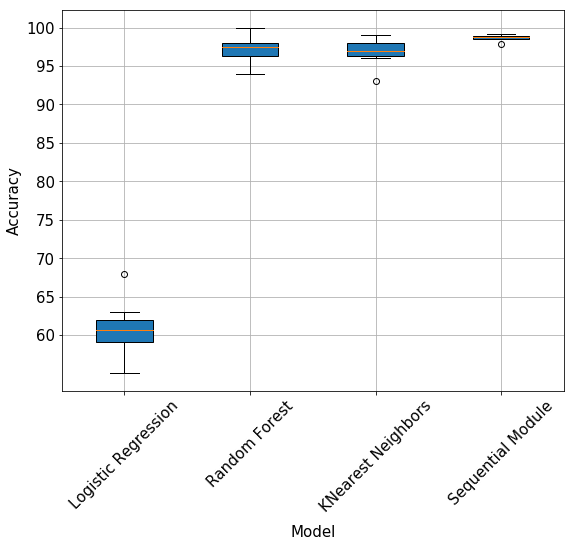

In [9]:
plt.figure(figsize=(9, 7))
ax = plt.axes()
plt.grid()
model_scores = [
   logreg_scores["test_score"]*100,
   randforest_scores["test_score"]*100,
   knn_scores["test_score"]*100,
   np.array(sequential_scores["test_score"])*100
]
model_names = [
   "Logistic Regression",
   "Random Forest",
   "KNearest Neighbors",
   "Sequential Module"
]

fontdict = {'fontsize': 15 }
# 'verticalalignment': 'baseline'}

ax.boxplot(model_scores, patch_artist=True)
ax.set_ylabel("Accuracy", fontdict=fontdict)
ax.set_yticks(np.arange(60,101,5))
ax.set_xlabel("Model", fontdict=fontdict, labelpad=10)
plt.ylim()



_ = ax.set_xticklabels(model_names, rotation=45, fontdict=fontdict)
_ = ax.set_yticklabels(np.arange(60,101,5), fontdict=fontdict)
# _ = ax.set_xticklabels(model_names, rotation=45)